In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rouge_score -q
!pip install bert_score -q

import pandas as pd
import re
import numpy as np
from typing import Dict, List
import seaborn as sns
from collections import defaultdict
from bert_score import score
from rouge_score import rouge_scorer
import torch
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100

print("="*60)
print("T5 AND FLAN-T5 EVALUATION")
print("="*60)

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00
T5 AND FLAN-T5 EVALUATION


In [ ]:
curated_results = pd.read_csv('/content/drive/MyDrive/Dissertation/T5/curated_t5_results.csv')
pilot_results = pd.read_csv('/content/drive/MyDrive/Dissertation/T5/pilot_t5_results.csv')

print(f"✓ Loaded curated results: {len(curated_results)} excerpts")
print(f"✓ Loaded pilot results: {len(pilot_results)} excerpts")


print(f"\nColumns in curated: {curated_results.columns.tolist()}")
print(f"Columns in pilot: {pilot_results.columns.tolist()}")

curated_t5 = curated_results
pilot_t5 = pilot_results
curated_flant5 = curated_results
pilot_flant5 = pilot_results


✓ Loaded curated results: 132 excerpts
✓ Loaded pilot results: 351 excerpts

Columns in curated: ['ID', 'Excerpt', 'Feature', 'SubFeature', 'GoldSummary', 't5_summary', 'flan_t5_summary']
Columns in pilot: ['ID', 'SPEAKER', 'TEXT', 'LING_FEATURES', 't5_summary', 'flan_t5_summary']


In [ ]:
def define_linguistic_patterns():
    """Define regex patterns for linguistic features"""

    patterns = {
        'hedges': r'\b(I think|I believe|maybe|perhaps|possibly|probably|seems?|appear(?:s|ed)?|'
                 r'kind of|sort of|somewhat|quite|rather|fairly|pretty much|basically|actually|'
                 r'I guess|I suppose|presumably|apparently|arguably|conceivably|'
                 r'in my opinion|if I recall|as far as I know|to my knowledge)\b',

        'modals': r'\b(might|may|could|would|should|must|ought to|'
                 r'can|cannot|can\'t|couldn\'t|wouldn\'t|shouldn\'t|'
                 r'shall|will|won\'t|mightn\'t|mayn\'t)\b',

        'conditionals': r'\b(if|unless|provided that|assuming|supposing|whether|'
                       r'in case|as long as|even if|only if|were|had|should)\b',

        'temporals': r'\b(before|after|during|while|when|then|at that time|at the time|'
                    r'previously|subsequently|meanwhile|simultaneously|eventually|'
                    r'back then|later on|earlier|afterwards|prior to|following)\b',

        'disfluencies': r'\b(um+|uh+|er+|ah+|mm+|hm+|hmm+)\b|'
                       r'\b(\w+)-\1\b|'  # Repetitions like "I-I"
                       r'\b(\w+)\s+\1\b(?!\w)|'  # Word repetitions
                       r'\.\.\.|—|--'  # Pauses
    }

    return patterns

def count_features(text, patterns):
    """Count linguistic features in text"""

    if pd.isna(text) or not text or text == 'nan':
        return {cat: 0 for cat in list(patterns.keys()) + ['total']}

    text = str(text)
    counts = {}

    for category, pattern in patterns.items():
        matches = re.findall(pattern, text, re.IGNORECASE)
        counts[category] = len(matches)

    counts['total'] = sum(counts.values())
    return counts

patterns = define_linguistic_patterns()

In [ ]:

def calculate_all_metrics(df, original_col, summary_col):
    """Calculate all preservation and quality metrics"""
    retention_results = {
        'hedges': [], 'modals': [], 'conditionals': [],
        'temporals': [], 'disfluencies': [], 'overall': []
    }

    complete_loss_count = 0
    total_with_features = 0
    disfluency_sanitization_rates = []
    certainty_inflation_count = 0
    compression_ratios = []

    for idx, row in df.iterrows():
        original = str(row[original_col])
        summary = str(row[summary_col])

        orig_counts = count_features(original, patterns)
        summ_counts = count_features(summary, patterns)

        # Feature Retention Rates
        for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
            if orig_counts[feature] > 0:
                retention = min(summ_counts[feature] / orig_counts[feature], 1.0)
            else:
                retention = 1.0
            retention_results[feature].append(retention)

        # Overall retention
        if orig_counts['total'] > 0:
            overall = min(summ_counts['total'] / orig_counts['total'], 1.0)
            retention_results['overall'].append(overall)

            total_with_features += 1
            if summ_counts['total'] == 0:
                complete_loss_count += 1
        else:
            retention_results['overall'].append(1.0)

        # Disfluency Sanitization
        if orig_counts['disfluencies'] > 0:
            retained = min(summ_counts['disfluencies'] / orig_counts['disfluencies'], 1.0)
            sanitization = (1 - retained) * 100
            disfluency_sanitization_rates.append(sanitization)
        else:
            disfluency_sanitization_rates.append(0)

        # Certainty Inflation
        if 'I think' in original.lower() and 'I think' not in summary.lower():
            certainty_inflation_count += 1

        # Compression Ratio
        orig_words = len(original.split())
        summ_words = len(summary.split())
        if orig_words > 0:
            compression = (summ_words / orig_words) * 100
            compression_ratios.append(compression)
        else:
            compression_ratios.append(0)

    # Calculate means
    results = {}
    for feature in retention_results:
        results[f'{feature}_retention'] = np.mean(retention_results[feature]) * 100

    results['complete_loss'] = (complete_loss_count / total_with_features * 100) if total_with_features > 0 else 0
    results['disfluency_sanitization'] = np.mean(disfluency_sanitization_rates)
    results['certainty_inflation'] = certainty_inflation_count
    results['compression_ratio'] = np.mean(compression_ratios)

    return results

In [ ]:

print("\nCurated T5:")
curated_t5_results = calculate_all_metrics(curated_t5, 'Excerpt', 't5_summary')
print(f"  Feature Retention Rates:")
for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
    print(f"    {feature}: {curated_t5_results[f'{feature}_retention']:.1f}%")
print(f"    overall: {curated_t5_results['overall_retention']:.1f}%")
print(f"  Certainty Inflation: {curated_t5_results['certainty_inflation']} instances")
print(f"  Disfluency Sanitization Rate: {curated_t5_results['disfluency_sanitization']:.1f}%")
print(f"  Complete Feature Loss: {curated_t5_results['complete_loss']:.1f}%")
print(f"  Compression Ratio: {curated_t5_results['compression_ratio']:.1f}%")

print("\n📊 CALCULATING METRICS FOR PILOT DATASET...")
print("-"*40)

pilot_t5_col = 'TEXT' if 'TEXT' in pilot_t5.columns else 'Excerpt'
print(f"Using column: {pilot_t5_col}")

print("\nPilot T5:")
pilot_t5_results = calculate_all_metrics(pilot_t5, pilot_t5_col, 't5_summary')
print(f"  Feature Retention Rates:")
for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
    print(f"    {feature}: {pilot_t5_results[f'{feature}_retention']:.1f}%")
print(f"    overall: {pilot_t5_results['overall_retention']:.1f}%")
print(f"  Certainty Inflation: {pilot_t5_results['certainty_inflation']} instances")
print(f"  Disfluency Sanitization Rate: {pilot_t5_results['disfluency_sanitization']:.1f}%")
print(f"  Complete Feature Loss: {pilot_t5_results['complete_loss']:.1f}%")
print(f"  Compression Ratio: {pilot_t5_results['compression_ratio']:.1f}%")




Curated T5:
  Feature Retention Rates:
    hedges: 86.1%
    modals: 95.4%
    conditionals: 92.8%
    temporals: 92.8%
    disfluencies: 86.7%
    overall: 81.2%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 13.3%
  Complete Feature Loss: 7.8%
  Compression Ratio: 176.6%

📊 CALCULATING METRICS FOR PILOT DATASET...
----------------------------------------
Using column: TEXT

Pilot T5:
  Feature Retention Rates:
    hedges: 92.3%
    modals: 95.7%
    conditionals: 93.4%
    temporals: 91.4%
    disfluencies: 82.0%
    overall: 83.0%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 18.0%
  Complete Feature Loss: 14.4%
  Compression Ratio: 300.6%


In [ ]:
#Flan T-5
print("\nCurated Flan-T5:")
curated_flant5_results = calculate_all_metrics(curated_flant5, 'Excerpt', 'flan_t5_summary')
print(f"  Feature Retention Rates:")
for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
    print(f"    {feature}: {curated_flant5_results[f'{feature}_retention']:.1f}%")
print(f"    overall: {curated_flant5_results['overall_retention']:.1f}%")
print(f"  Certainty Inflation: {curated_flant5_results['certainty_inflation']} instances")
print(f"  Disfluency Sanitization Rate: {curated_flant5_results['disfluency_sanitization']:.1f}%")
print(f"  Complete Feature Loss: {curated_flant5_results['complete_loss']:.1f}%")
print(f"  Compression Ratio: {curated_flant5_results['compression_ratio']:.1f}%")

print("\n📊 CALCULATING METRICS FOR PILOT DATASET...")
print("-"*40)

pilot_flant5_col = 'TEXT' if 'TEXT' in pilot_flant5.columns else 'Excerpt'

print("\nPilot Flan-T5:")
pilot_flant5_results = calculate_all_metrics(pilot_flant5, pilot_flant5_col, 'flan_t5_summary')
print(f"  Feature Retention Rates:")
for feature in ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']:
    print(f"    {feature}: {pilot_flant5_results[f'{feature}_retention']:.1f}%")
print(f"    overall: {pilot_flant5_results['overall_retention']:.1f}%")
print(f"  Certainty Inflation: {pilot_flant5_results['certainty_inflation']} instances")
print(f"  Disfluency Sanitization Rate: {pilot_flant5_results['disfluency_sanitization']:.1f}%")
print(f"  Complete Feature Loss: {pilot_flant5_results['complete_loss']:.1f}%")
print(f"  Compression Ratio: {pilot_flant5_results['compression_ratio']:.1f}%")

print("\n" + "="*60)


Curated Flan-T5:
  Feature Retention Rates:
    hedges: 86.4%
    modals: 87.6%
    conditionals: 92.2%
    temporals: 93.6%
    disfluencies: 87.5%
    overall: 76.9%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 12.5%
  Complete Feature Loss: 15.5%
  Compression Ratio: 170.6%

📊 CALCULATING METRICS FOR PILOT DATASET...
----------------------------------------

Pilot Flan-T5:
  Feature Retention Rates:
    hedges: 93.6%
    modals: 91.1%
    conditionals: 88.8%
    temporals: 87.7%
    disfluencies: 81.0%
    overall: 70.8%
  Certainty Inflation: 0 instances
  Disfluency Sanitization Rate: 19.0%
  Complete Feature Loss: 37.4%
  Compression Ratio: 392.9%



In [ ]:

print("\n📊 CALCULATING QUALITY METRICS...")
print("-"*50)

def calculate_rouge_l(df, reference_col, summary_col):
    """Calculate ROUGE-L scores"""
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = []

    for idx, row in df.iterrows():
        reference = str(row[reference_col])
        summary = str(row[summary_col])

        if pd.isna(summary) or summary == 'nan' or not summary:
            rouge_scores.append(0)
            continue

        scores = scorer.score(reference, summary)
        rouge_scores.append(scores['rougeL'].fmeasure)

    return np.mean(rouge_scores) * 100

def calculate_bertscore(df, reference_col, summary_col, batch_size=16):
    """Calculate BERTScore"""
    references = []
    summaries = []

    for idx, row in df.iterrows():
        reference = str(row[reference_col])
        summary = str(row[summary_col])

        if pd.isna(summary) or summary == 'nan' or not summary:
            summary = ""

        references.append(reference)
        summaries.append(summary)

    P, R, F1 = score(summaries, references,
                     lang='en',
                     model_type='microsoft/deberta-base-mnli',
                     batch_size=batch_size,
                     verbose=False,
                     device='cuda' if torch.cuda.is_available() else 'cpu')

    bertscore_f1 = F1.numpy() * 100
    return np.mean(bertscore_f1)

# Calculate for T5
print("\n📈 T5 Quality Metrics:")
curated_t5_results['rouge_l'] = calculate_rouge_l(curated_t5, 'Excerpt', 't5_summary')
pilot_t5_results['rouge_l'] = calculate_rouge_l(pilot_t5, pilot_t5_col, 't5_summary')

try:
    curated_t5_results['bertscore'] = calculate_bertscore(curated_t5, 'Excerpt', 't5_summary')
    pilot_t5_results['bertscore'] = calculate_bertscore(pilot_t5, pilot_t5_col, 't5_summary')
except:
    curated_t5_results['bertscore'] = 0
    pilot_t5_results['bertscore'] = 0

print(f"  Curated - ROUGE-L: {curated_t5_results['rouge_l']:.1f}%, BERTScore: {curated_t5_results['bertscore']:.1f}%")
print(f"  Pilot - ROUGE-L: {pilot_t5_results['rouge_l']:.1f}%, BERTScore: {pilot_t5_results['bertscore']:.1f}%")

# Calculate for Flan-T5
print("\n📈 Flan-T5 Quality Metrics:")
curated_flant5_results['rouge_l'] = calculate_rouge_l(curated_flant5, 'Excerpt', 'flan_t5_summary')
pilot_flant5_results['rouge_l'] = calculate_rouge_l(pilot_flant5, pilot_flant5_col, 'flan_t5_summary')

try:
    curated_flant5_results['bertscore'] = calculate_bertscore(curated_flant5, 'Excerpt', 'flan_t5_summary')
    pilot_flant5_results['bertscore'] = calculate_bertscore(pilot_flant5, pilot_flant5_col, 'flan_t5_summary')
except:
    curated_flant5_results['bertscore'] = 0
    pilot_flant5_results['bertscore'] = 0

print(f"  Curated - ROUGE-L: {curated_flant5_results['rouge_l']:.1f}%, BERTScore: {curated_flant5_results['bertscore']:.1f}%")
print(f"  Pilot - ROUGE-L: {pilot_flant5_results['rouge_l']:.1f}%, BERTScore: {pilot_flant5_results['bertscore']:.1f}%")



📊 CALCULATING QUALITY METRICS...
--------------------------------------------------

📈 T5 Quality Metrics:


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/557M [00:00<?, ?B/s]

  Curated - ROUGE-L: 59.7%, BERTScore: 75.0%
  Pilot - ROUGE-L: 50.7%, BERTScore: 72.8%

📈 Flan-T5 Quality Metrics:


  Curated - ROUGE-L: 55.5%, BERTScore: 74.3%
  Pilot - ROUGE-L: 45.0%, BERTScore: 67.7%



CREATING VISUALIZATIONS


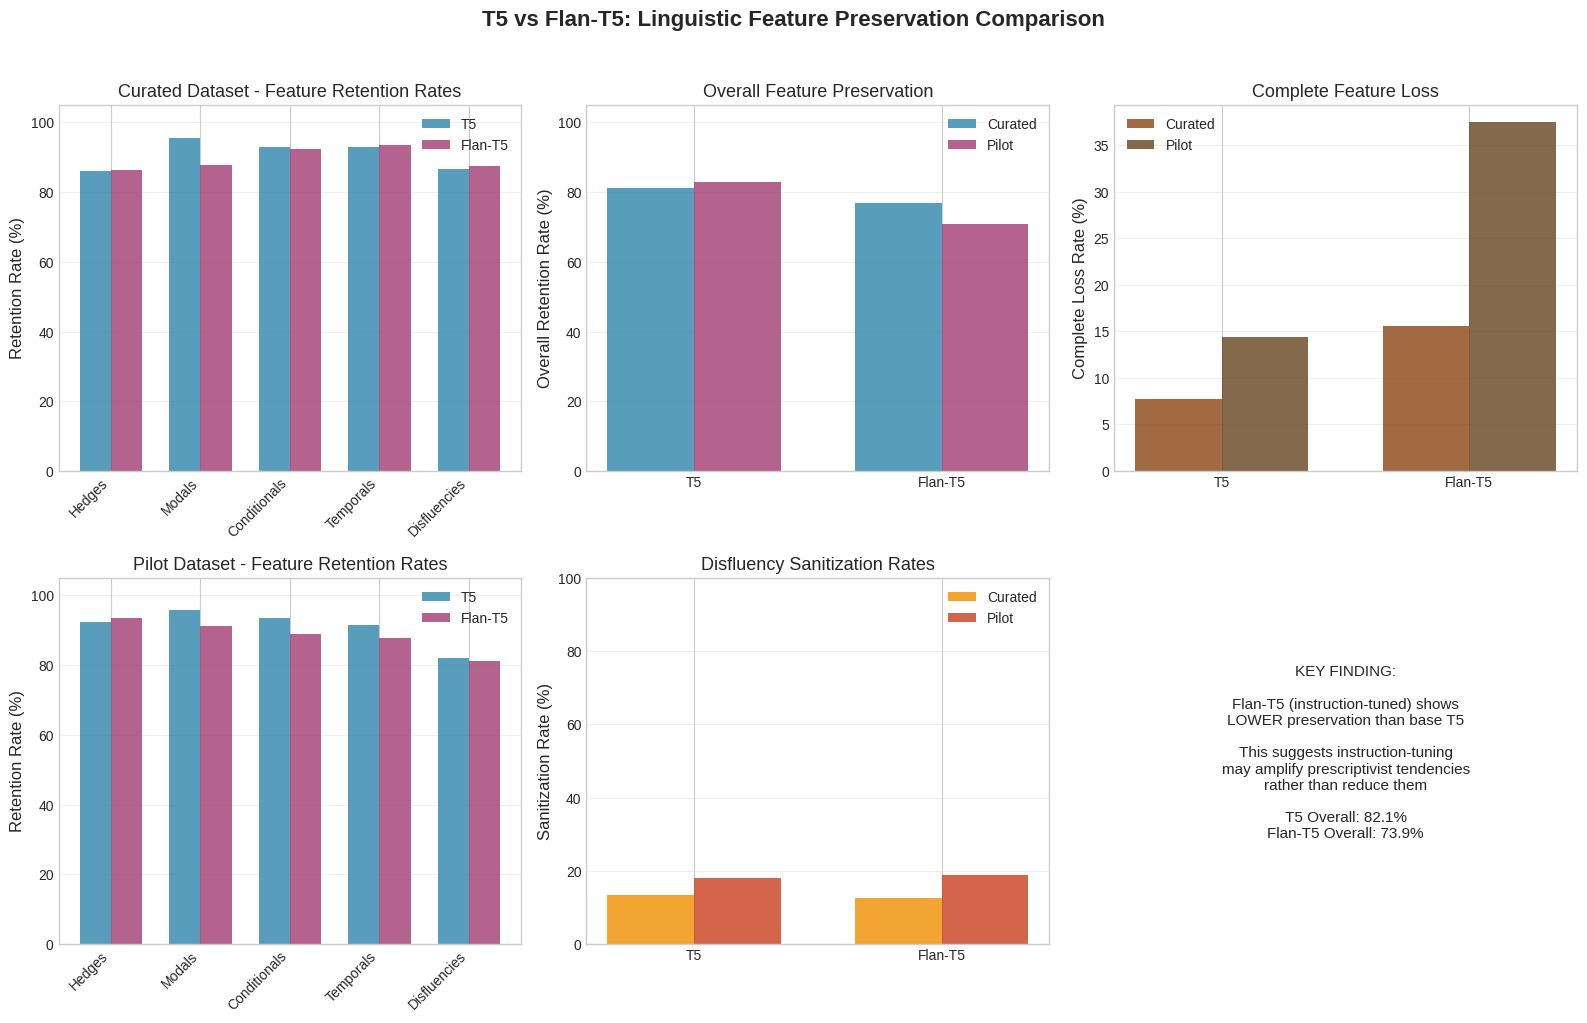

✓ Saved: t5_flant5_comparison.png


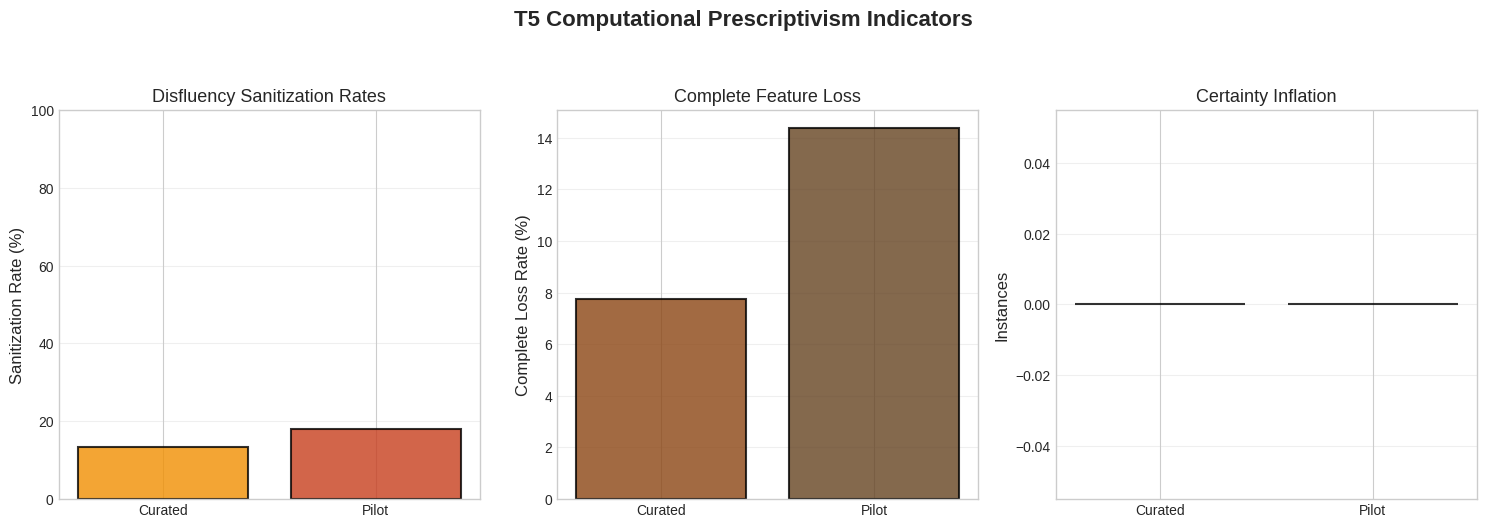

✓ Saved: t5_prescriptivism_indicators.png


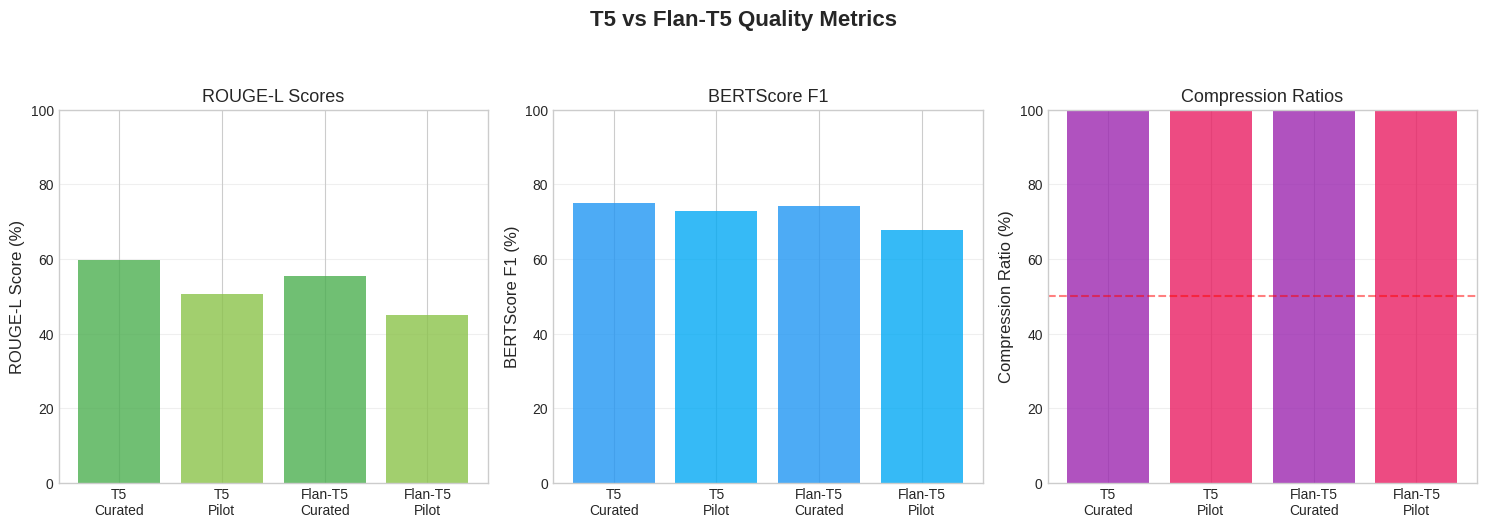

✓ Saved: t5_flant5_quality_metrics.png

✅ T5 AND FLAN-T5 EVALUATION COMPLETE

📊 SUMMARY COMPARISON:
----------------------------------------
T5 Average Overall Retention: 82.1%
Flan-T5 Average Overall Retention: 73.9%

T5 Average Disfluency Sanitization: 15.7%
Flan-T5 Average Disfluency Sanitization: 15.7%

⚠️ Flan-T5 shows LOWER preservation than base T5
   Instruction-tuning appears to amplify prescriptivist tendencies


In [ ]:


print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# FIGURE 1: Feature Retention Comparison for both models
fig1, axes = plt.subplots(2, 3, figsize=(16, 10))
fig1.suptitle('T5 vs Flan-T5: Linguistic Feature Preservation Comparison',
              fontsize=16, fontweight='bold', y=1.02)

features = ['hedges', 'modals', 'conditionals', 'temporals', 'disfluencies']
feature_labels = ['Hedges', 'Modals', 'Conditionals', 'Temporals', 'Disfluencies']

# Curated - Feature retention comparison
ax = axes[0, 0]
x = np.arange(len(features))
width = 0.35

t5_values = [curated_t5_results[f'{f}_retention'] for f in features]
flant5_values = [curated_flant5_results[f'{f}_retention'] for f in features]

bars1 = ax.bar(x - width/2, t5_values, width, label='T5', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, flant5_values, width, label='Flan-T5', color='#A23B72', alpha=0.8)

ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.set_title('Curated Dataset - Feature Retention Rates', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(feature_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

# Pilot - Feature retention comparison
ax = axes[1, 0]
t5_values = [pilot_t5_results[f'{f}_retention'] for f in features]
flant5_values = [pilot_flant5_results[f'{f}_retention'] for f in features]

bars1 = ax.bar(x - width/2, t5_values, width, label='T5', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x + width/2, flant5_values, width, label='Flan-T5', color='#A23B72', alpha=0.8)

ax.set_ylabel('Retention Rate (%)', fontsize=12)
ax.set_title('Pilot Dataset - Feature Retention Rates', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(feature_labels, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

# Overall retention comparison
ax = axes[0, 1]
models = ['T5', 'Flan-T5']
curated_overall = [curated_t5_results['overall_retention'], curated_flant5_results['overall_retention']]
pilot_overall = [pilot_t5_results['overall_retention'], pilot_flant5_results['overall_retention']]

x2 = np.arange(len(models))
bars1 = ax.bar(x2 - width/2, curated_overall, width, label='Curated', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x2 + width/2, pilot_overall, width, label='Pilot', color='#A23B72', alpha=0.8)

ax.set_ylabel('Overall Retention Rate (%)', fontsize=12)
ax.set_title('Overall Feature Preservation', fontsize=13)
ax.set_xticks(x2)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)

# Disfluency sanitization comparison
ax = axes[1, 1]
curated_disf = [curated_t5_results['disfluency_sanitization'], curated_flant5_results['disfluency_sanitization']]
pilot_disf = [pilot_t5_results['disfluency_sanitization'], pilot_flant5_results['disfluency_sanitization']]

bars1 = ax.bar(x2 - width/2, curated_disf, width, label='Curated', color='#F18F01', alpha=0.8)
bars2 = ax.bar(x2 + width/2, pilot_disf, width, label='Pilot', color='#C73E1D', alpha=0.8)

ax.set_ylabel('Sanitization Rate (%)', fontsize=12)
ax.set_title('Disfluency Sanitization Rates', fontsize=13)
ax.set_xticks(x2)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Complete loss comparison
ax = axes[0, 2]
curated_loss = [curated_t5_results['complete_loss'], curated_flant5_results['complete_loss']]
pilot_loss = [pilot_t5_results['complete_loss'], pilot_flant5_results['complete_loss']]

bars1 = ax.bar(x2 - width/2, curated_loss, width, label='Curated', color='#8B4513', alpha=0.8)
bars2 = ax.bar(x2 + width/2, pilot_loss, width, label='Pilot', color='#654321', alpha=0.8)

ax.set_ylabel('Complete Loss Rate (%)', fontsize=12)
ax.set_title('Complete Feature Loss', fontsize=13)
ax.set_xticks(x2)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Key finding text
ax = axes[1, 2]
finding_text = """KEY FINDING:

Flan-T5 (instruction-tuned) shows
LOWER preservation than base T5

This suggests instruction-tuning
may amplify prescriptivist tendencies
rather than reduce them

T5 Overall: {:.1f}%
Flan-T5 Overall: {:.1f}%
""".format(
    np.mean([curated_t5_results['overall_retention'], pilot_t5_results['overall_retention']]),
    np.mean([curated_flant5_results['overall_retention'], pilot_flant5_results['overall_retention']])
)

ax.text(0.5, 0.5, finding_text, ha='center', va='center', fontsize=11, transform=ax.transAxes)
ax.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/T5/t5_flant5_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: t5_flant5_comparison.png")

# FIGURE 2: Standard format visualizations for T5
fig2, axes = plt.subplots(1, 3, figsize=(15, 5))
fig2.suptitle('T5 Computational Prescriptivism Indicators',
              fontsize=16, fontweight='bold', y=1.05)

# Disfluency Sanitization
ax1 = axes[0]
sanitization_data = {
    'Curated': curated_t5_results['disfluency_sanitization'],
    'Pilot': pilot_t5_results['disfluency_sanitization']
}
bars = ax1.bar(sanitization_data.keys(), sanitization_data.values(),
               color=['#F18F01', '#C73E1D'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Sanitization Rate (%)', fontsize=12)
ax1.set_title('Disfluency Sanitization Rates', fontsize=13)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Complete Feature Loss
ax2 = axes[1]
loss_data = {
    'Curated': curated_t5_results['complete_loss'],
    'Pilot': pilot_t5_results['complete_loss']
}
bars = ax2.bar(loss_data.keys(), loss_data.values(),
               color=['#8B4513', '#654321'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Complete Loss Rate (%)', fontsize=12)
ax2.set_title('Complete Feature Loss', fontsize=13)
ax2.grid(axis='y', alpha=0.3)

# Certainty Inflation
ax3 = axes[2]
inflation_data = {
    'Curated': curated_t5_results['certainty_inflation'],
    'Pilot': pilot_t5_results['certainty_inflation']
}
bars = ax3.bar(inflation_data.keys(), inflation_data.values(),
               color=['#DC143C', '#8B0000'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Instances', fontsize=12)
ax3.set_title('Certainty Inflation', fontsize=13)
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/T5/t5_prescriptivism_indicators.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: t5_prescriptivism_indicators.png")

# FIGURE 3: Quality metrics comparison
fig3, axes = plt.subplots(1, 3, figsize=(15, 5))
fig3.suptitle('T5 vs Flan-T5 Quality Metrics', fontsize=16, fontweight='bold', y=1.05)

# ROUGE-L
ax1 = axes[0]
models = ['T5\nCurated', 'T5\nPilot', 'Flan-T5\nCurated', 'Flan-T5\nPilot']
rouge_values = [curated_t5_results['rouge_l'], pilot_t5_results['rouge_l'],
                curated_flant5_results['rouge_l'], pilot_flant5_results['rouge_l']]

bars = ax1.bar(models, rouge_values, color=['#4CAF50', '#8BC34A']*2, alpha=0.8)
ax1.set_ylabel('ROUGE-L Score (%)', fontsize=12)
ax1.set_title('ROUGE-L Scores', fontsize=13)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# BERTScore
ax2 = axes[1]
bert_values = [curated_t5_results['bertscore'], pilot_t5_results['bertscore'],
               curated_flant5_results['bertscore'], pilot_flant5_results['bertscore']]

bars = ax2.bar(models, bert_values, color=['#2196F3', '#03A9F4']*2, alpha=0.8)
ax2.set_ylabel('BERTScore F1 (%)', fontsize=12)
ax2.set_title('BERTScore F1', fontsize=13)
ax2.set_ylim(0, 100)
ax2.grid(axis='y', alpha=0.3)

# Compression Ratio
ax3 = axes[2]
comp_values = [curated_t5_results['compression_ratio'], pilot_t5_results['compression_ratio'],
               curated_flant5_results['compression_ratio'], pilot_flant5_results['compression_ratio']]

bars = ax3.bar(models, comp_values, color=['#9C27B0', '#E91E63']*2, alpha=0.8)
ax3.set_ylabel('Compression Ratio (%)', fontsize=12)
ax3.set_title('Compression Ratios', fontsize=13)
ax3.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax3.set_ylim(0, 100)
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Dissertation/T5/t5_flant5_quality_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: t5_flant5_quality_metrics.png")

print("\n" + "="*60)
print(" T5 AND FLAN-T5 EVALUATION COMPLETE")
print("="*60)

print("\n SUMMARY COMPARISON:")
print("-"*40)
print(f"T5 Average Overall Retention: {np.mean([curated_t5_results['overall_retention'], pilot_t5_results['overall_retention']]):.1f}%")
print(f"Flan-T5 Average Overall Retention: {np.mean([curated_flant5_results['overall_retention'], pilot_flant5_results['overall_retention']]):.1f}%")
print(f"\nT5 Average Disfluency Sanitization: {np.mean([curated_t5_results['disfluency_sanitization'], pilot_t5_results['disfluency_sanitization']]):.1f}%")
print(f"Flan-T5 Average Disfluency Sanitization: {np.mean([curated_flant5_results['disfluency_sanitization'], pilot_flant5_results['disfluency_sanitization']]):.1f}%")

if np.mean([curated_flant5_results['overall_retention'], pilot_flant5_results['overall_retention']]) < \
   np.mean([curated_t5_results['overall_retention'], pilot_t5_results['overall_retention']]):
    print("\n Flan-T5 shows LOWER preservation than base T5")
    print("   Instruction-tuning appears to amplify prescriptivist tendencies")